# Exploration

## Imports

In [ ]:
#conda install tensorflow

In [111]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import output#oven timer

## Load Data

In [6]:
print(os.getcwd())
#Path of the data folder
#data_path = "C:/Users/Admin/OneDrive - McGill University/COMP551550git/NLP-Authorship-Latin-Eng\Data"
data_path = ""
os.path.exists(data_path)

/content


False

### TensorFlow

In [ ]:
training_data = pd.read_csv((data_path + "/Train_Data/train_data_pre_processed_lemmatized.csv"))
validation_data = pd.read_csv((data_path + "/Validation_Data/pre_processed/validation_data_lemmatized.csv"))
test_data = pd.read_csv((data_path + "/Test_Data/pre_processed/test_data_lemmatized.csv"))

In [41]:
training_data = pd.read_csv((data_path + "translated_data_train_16k_format_fix.csv"))
validation_data = pd.read_csv((data_path + "validation_data_filtered.csv"))
test_data = pd.read_csv((data_path + "test_data_filtered.csv"))

In [112]:
label_list = ['final_alignments\\Vulgate_Bible.json',
       'final_alignments\\Cato_Agriculture.json',
       'final_alignments\\Tertullian_Apology.json',
       'final_alignments\\Sallust_Jugurtha.json',
       'final_alignments\\Velleius_Paterculus_Compendium.json'] #string labels converted to ints

def data_prep(df, label_list = label_list, label_name = 'file', text_name = 'la'):
  df[label_name].replace(label_list,range(len(label_list)), inplace=True)
  labels_one_hot = tf.keras.utils.to_categorical(df[label_name].values, len(label_list))
  return tf.data.Dataset.from_tensor_slices((df[text_name].values,labels_one_hot))
def oven_timer():
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')#Beep when complete, bread is baked


In [114]:
training_data_la = data_prep(training_data,text_name = 'la')
training_data_en = data_prep(training_data,text_name = 'en')
training_data_en.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.float32, name=None))

In [115]:
validation_data_la = data_prep(validation_data,text_name = 'la')
validation_data_en = data_prep(validation_data,text_name = 'en')
validation_data.head(1)

,Unnamed: 0,id,la,en,file
0,14,2,Quid si noluerint vel nullae fuerint? quid den...,"But if they wont come, or if you have none? Wh...",2


In [116]:
test_data_la = data_prep(test_data,text_name = 'la')
test_data_en = data_prep(test_data,text_name = 'en')
test_data.head(1)

,Unnamed: 0,id,la,en,file
0,1,1,super aspidem et basiliscum calcabis conculcab...,super aspidem et basiliscum ambulabis et; conc...,0


In [117]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
training_data_la = training_data_la.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_data_la = validation_data_la.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data_la = test_data_la.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

training_data_en = training_data_en.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_data_en = validation_data_en.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data_en = test_data_en.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

##Vectorization

In [118]:
VOCAB_SIZE = 5000
encoder_la = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder_la.adapt(training_data_la.map(lambda text, label: text))

encoder_en = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder_en.adapt(training_data_en.map(lambda text, label: text))

In [119]:
np.array(encoder_la.get_vocabulary())[0:20] #dtype?

array(['', '[UNK]', 'et', 'in', 'est', 'non', 'ad', 'cum', 'quod', 'de',
       'qui', 'ut', 'si', 'sed', 'vel', 'quae', 'a', 'quam', 'ex', 'aut'],
      dtype='<U16')

In [92]:
np.array(encoder_en.get_vocabulary())[0:20] #dtype?

array(['', '[UNK]', 'the', 'of', 'and', 'to', 'in', 'a', 'that', 'he',
       'his', 'for', 'was', 'it', 'with', 'is', 'not', 'by', 'you', 'had'],
      dtype='<U14')

#Compose Layers

##Latin


 sequential model is used here since all the layers in the model only have single input and produce single output.

In [122]:
model_la = tf.keras.Sequential([
    encoder_la,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_la.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),

    #A recurrent neural network (RNN) processes sequence input by iterating through the elements.
    #RNNs pass the outputs from one timestep to their input on the next timestep.
    #The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer.
    #This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # final processing, and convert from this vector representation to a single logit as the classification output.
    tf.keras.layers.Dense(64, activation='relu'), #Relu activation
    tf.keras.layers.Dense(len(label_list), activation='softmax')  # Adjust the output size based on the number of classes
])

model_la.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),#lr 1e-4
              metrics=['accuracy'])
history_la = model_la.fit(training_data_la, epochs=12,
                    validation_data=validation_data_la,
                    validation_steps=30)

oven_timer()

test_loss, test_acc = model_la.evaluate(test_data_la)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


273/273 [==============================] - ETA: 0s - loss: 1.5672 - accuracy: 0.3399

273/273 [==============================] - 43s 126ms/step - loss: 1.5672 - accuracy: 0.3399 - val_loss: 1.3988 - val_accuracy: 0.6612
Epoch 2/10
273/273 [==============================] - 33s 122ms/step - loss: 1.1409 - accuracy: 0.5701
Epoch 3/10
273/273 [==============================] - 32s 116ms/step - loss: 0.7944 - accuracy: 0.7210
Epoch 4/10
273/273 [==============================] - 32s 117ms/step - loss: 0.6186 - accuracy: 0.7869
Epoch 5/10
273/273 [==============================] - 31s 115ms/step - loss: 0.5174 - accuracy: 0.8242
Epoch 6/10
273/273 [==============================] - 32s 119ms/step - loss: 0.4461 - accuracy: 0.8538
Epoch 7/10
273/273 [==============================] - 31s 115ms/step - loss: 0.3889 - accuracy: 0.8741
Epoch 8/10
273/273 [==============================] - 32s 118ms/step - loss: 0.3444 - accuracy: 0.8882
Epoch 9/10
273/273 [==============================] - 32s 119ms/step - loss: 0.3100 - accuracy: 0.9018
Epoch 10/10
273/273 [=====================

## English

In [124]:
model_en = tf.keras.Sequential([
    encoder_en,
    tf.keras.layers.Embedding( input_dim=len(encoder_en.get_vocabulary()), output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_list), activation='softmax')
])
model_en.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),#lr 1e-4
              metrics=['accuracy'])
history_en = model_en.fit(training_data_en, epochs=12,
                    validation_data=validation_data_en,
                    validation_steps=30)
oven_timer()
test_loss, test_acc = model_en.evaluate(test_data_en)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/10
273/273 [==============================] - ETA: 0s - loss: 1.4784 - accuracy: 0.4307

273/273 [==============================] - 72s 229ms/step - loss: 1.4784 - accuracy: 0.4307 - val_loss: 1.5429 - val_accuracy: 0.1157
Epoch 2/10
273/273 [==============================] - 59s 217ms/step - loss: 1.0102 - accuracy: 0.6140
Epoch 3/10
273/273 [==============================] - 58s 211ms/step - loss: 0.7496 - accuracy: 0.7557
Epoch 4/10
273/273 [==============================] - 60s 220ms/step - loss: 0.5479 - accuracy: 0.8386
Epoch 5/10
273/273 [==============================] - 58s 214ms/step - loss: 0.4123 - accuracy: 0.8799
Epoch 6/10
273/273 [==============================] - 59s 215ms/step - loss: 0.3285 - accuracy: 0.9066
Epoch 7/10
273/273 [==============================] - 59s 218ms/step - loss: 0.2518 - accuracy: 0.9282
Epoch 8/10
273/273 [==============================] - 58s 213ms/step - loss: 0.1979 - accuracy: 0.9472
Epoch 9/10
273/273 [==============================] - 60s 219ms/step - loss: 0.1697 - accuracy: 0.9563
Epoch 10/10
273/273 [=====================

In [125]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.63167734593153)

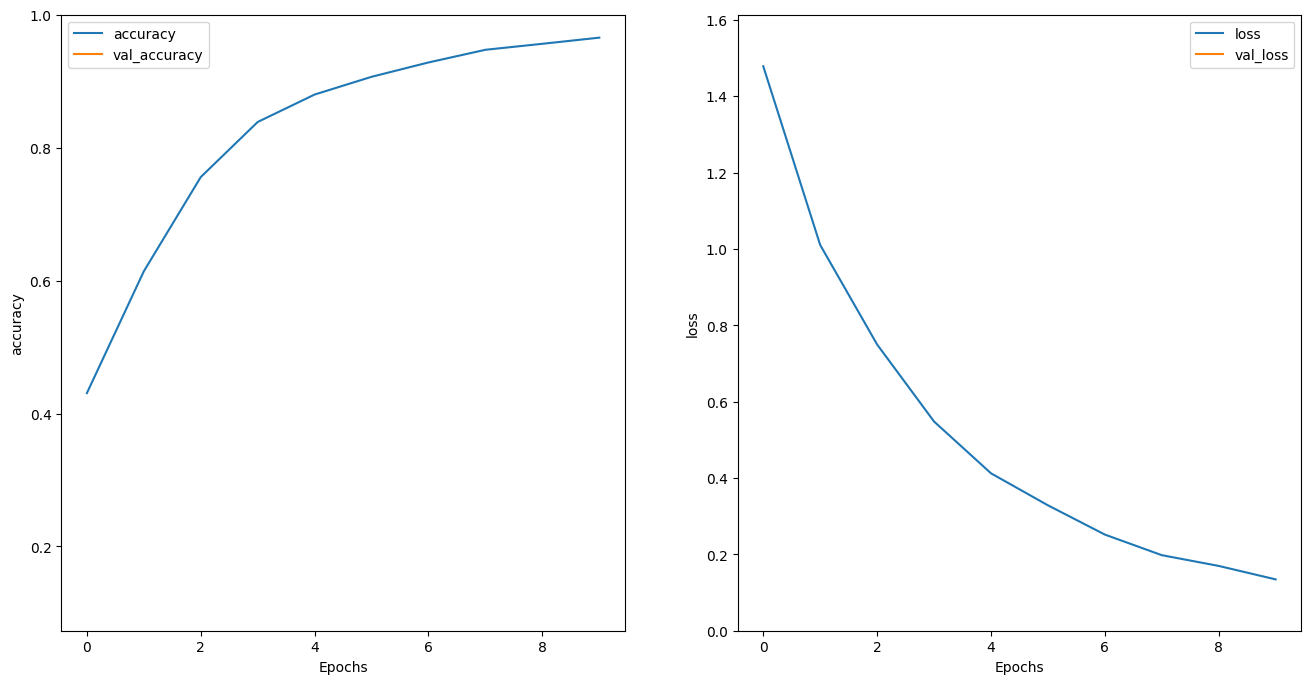

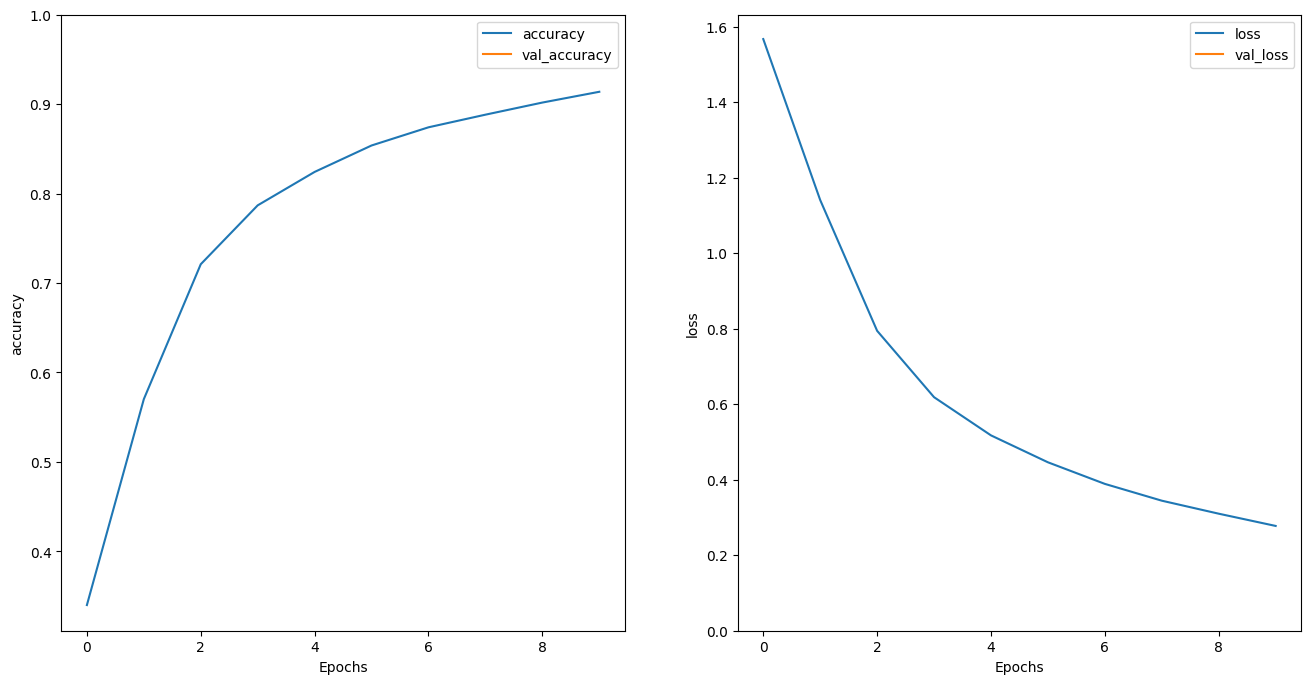

In [128]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_en, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_en, 'loss')
plt.ylim(0, None)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_la, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_la, 'loss')
plt.ylim(0, None)

In [129]:

test_loss, test_acc = model_en.evaluate(test_data_en)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

6/6 [==============================] - 0s 32ms/step - loss: 0.5842 - accuracy: 0.8472
Test Loss: 0.5841511487960815
Test Accuracy: 0.8472222089767456


In [130]:
test_loss, test_acc = model_la.evaluate(test_data_la)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

6/6 [==============================] - 0s 21ms/step - loss: 0.8229 - accuracy: 0.8111
Test Loss: 0.8228954672813416
Test Accuracy: 0.8111110925674438
